In [4]:
#----------------------------------------------------------------
# Load libraries
#----------------------------------------------------------------
import numpy as np
import math
from gwpy.timeseries import TimeSeries

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import lmfit

import os

%matplotlib inline

In [5]:
#----------------------------------------------------------------
# Set parameters
#----------------------------------------------------------------
fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5' # data file
tevent = 1126259462.422 # Mon Sep 14 09:50:45 GMT 2015
evtname = 'GW150914' # event name

detector = 'L1' # detecotr: L1 or H1

In [6]:
#----------------------------------------------------------------
# Load LIGO data
#----------------------------------------------------------------
strain = TimeSeries.read(fn, format='hdf5.losc')
center = int(tevent)
strain = strain.crop(center-16, center+16)

<Figure size 432x288 with 0 Axes>

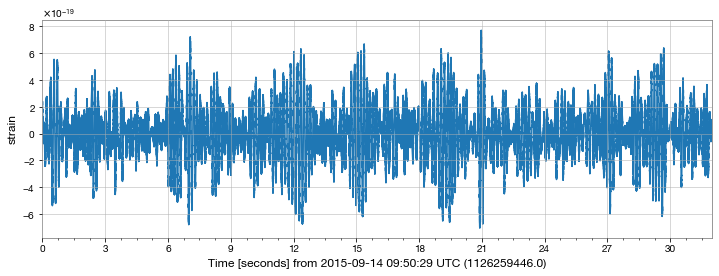

In [7]:
#----------------------------------------------------------------
# Show LIGO strain vs. time
#----------------------------------------------------------------
plt.figure()
strain.plot()
plt.ylabel('strain')
plt.show()

<Figure size 432x288 with 0 Axes>

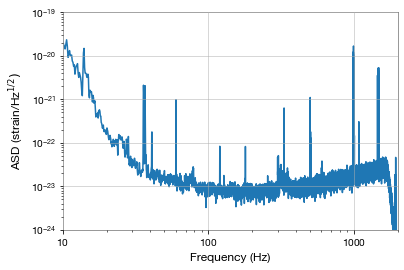

In [8]:
#----------------------------------------------------------------
# Obtain the power spectrum density PSD / ASD
#----------------------------------------------------------------

asd = strain.asd(fftlength=8)

plt.clf()
asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

<Figure size 432x288 with 0 Axes>

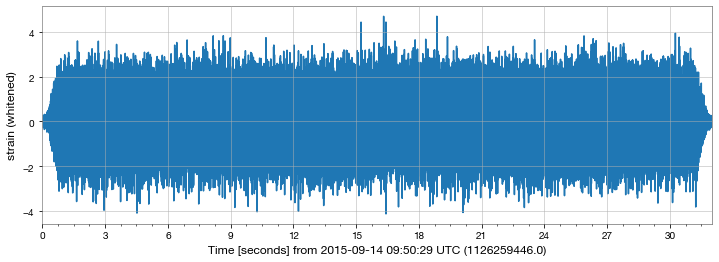

In [9]:
#----------------------------------------------------------------
# Whitening data
#----------------------------------------------------------------

white_data = strain.whiten()

plt.clf()
white_data.plot()
plt.ylabel('strain (whitened)')
plt.show()

<Figure size 432x288 with 0 Axes>

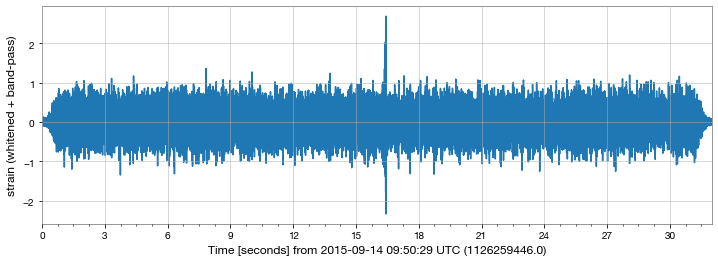

<Figure size 432x288 with 0 Axes>

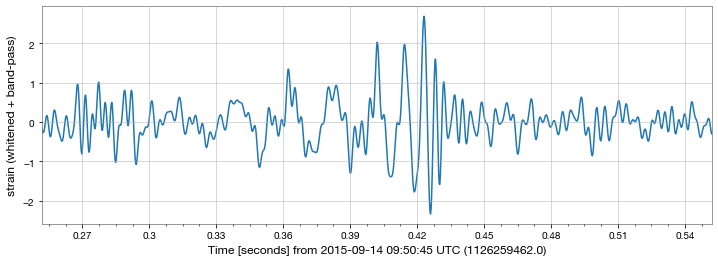

In [10]:
#----------------------------------------------------------------
# Bandpass filtering
#----------------------------------------------------------------

bandpass_low = 30
bandpass_high = 350

white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)

plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')

plt.figure()
#--------------------------------------------
# Zoom in on signal
# -------------------------------------------
plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.xlim(tevent-.17, tevent+.13)
plt.show()



In [11]:
# #----------------------------------------------------------------
# # q-transform
# #----------------------------------------------------------------

# dt = 1  #-- Set width of q-transform plot, in seconds
# hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))

# plt.clf()
# fig = hq.plot()
# ax = fig.gca()
# fig.colorbar(label="Normalised energy")
# ax.grid(False)
# plt.xlim(tevent-0.5, tevent+0.4)
# plt.ylim(0, 400)
# plt.ylabel('Frequency (Hz)')
# plt.show()

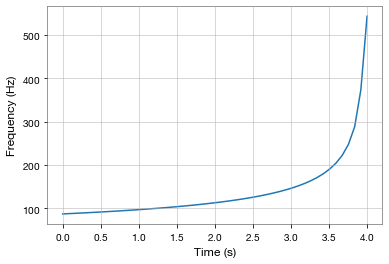

In [12]:
#----------------------------------------------------------------
# Frequency analytic
#----------------------------------------------------------------

def gwfreq(iM,iT,iT0):
    const = (948.5)*np.power((1./iM),5./8.)
    output = const*np.power(np.maximum((iT0-iT),3e-2),-3./8.) # we can max it out above 500 Hz-ish
    return output

times = np.linspace(0., 4., 50)
freq = gwfreq(20, times, 4)

plt.clf()
plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

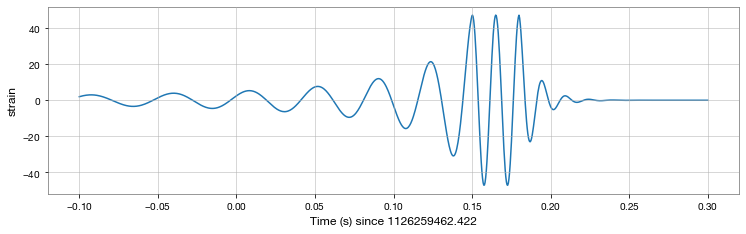

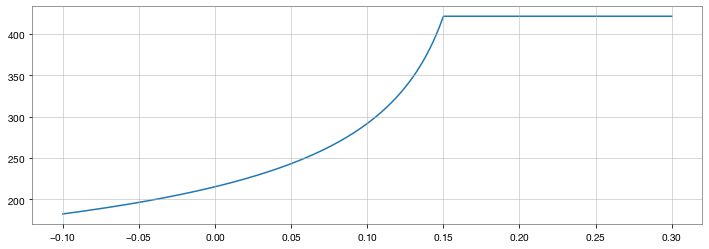

In [13]:
#----------------------------------------------------------------
# Model fit function
#----------------------------------------------------------------

def osc(t, Mc, t0, C, phi):
    vals = []
    for time in t:
        if time <= t0:
            vals.append(C*1e-12 * (Mc * gwfreq(Mc, time, t0))**(10/3) * np.cos(gwfreq(Mc, time, t0) * (time-t0) + phi))
        else:
            vals.append(np.exp(-100*(time-t0)) * C*1e-12 * (Mc * gwfreq(Mc, time, t0))**(10/3) * np.cos(gwfreq(Mc, time, t0) * (time-t0) + phi))

    return np.asarray(vals)

# Draw the function defined
times = np.linspace(-0.1, 0.3, 1000)
freq = osc(times, 30, 0.18, 1, 0.0)
omega = gwfreq(30, times, .18)
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, freq)
plt.xlabel('Time (s) since '+str(tevent))
plt.ylabel('strain')

plt.figure(figsize=(12, 4))
plt.plot(times, omega)

plt.show()


In [14]:
# define osc_dif for lmfit::minimize()
def osc_dif(params, x, data, eps):
    iM=params["Mc"]
    iT0=params["t0"]
    norm=params["C"]
    phi=params["phi"]
    val=osc(x, iM, iT0, norm, phi)
    return (val-data)/eps

[20 20 20 ... 20 20 20]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 1228
    # variables        = 4
    chi-square         = 0.66382070
    reduced chi-square = 5.4234e-04
    Akaike info crit   = -9230.10315
    Bayesian info crit = -9209.65058
[[Variables]]
    Mc:   17.4952612 +/- 0.18851610 (1.08%) (init = 20)
    t0:   0.18017190 +/- 5.4115e-04 (0.30%) (init = 0.18)
    C:   -0.04256338 +/- 0.00191436 (4.50%) (init = 1)
    phi:  1.88821293 +/- 0.34759168 (18.41%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) =  0.981
    C(Mc, phi) = -0.892
    C(Mc, t0)  = -0.823
    C(Mc, C)   =  0.251
    C(C, phi)  = -0.206
    C(t0, C)   = -0.185


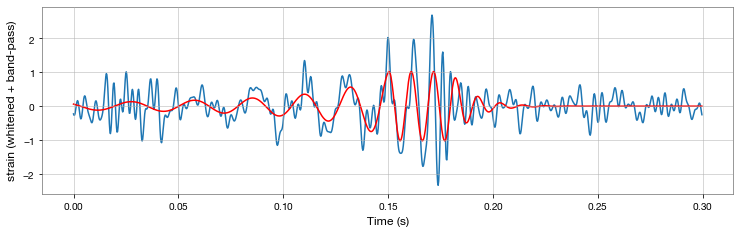

In [19]:
#----------------------------------------------------------------
# Fit
#----------------------------------------------------------------

sample_times = white_data_bp.times.value
sample_data = white_data_bp.value
indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

# import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(20)     # Mass guess
p['t0'].set(0.18)  # By construction we put the merger in the center
p['C'].set(1)      # normalization guess
p['phi'].set(0)    # Phase guess
unc = np.full(len(white_data_bp_zoom),20)
print(unc)
out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
plt.show()